In [1]:
# imports
import atc_dataloader, atc_model
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from atc_loss import PredictionLoss_COS_MSE, PredictionLoss_BOX_Wise
import time

In [2]:
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def transform_vector_to_integers(pred):
    # //////////////////////////////////////////////////////////
    # CURRENTLY NOT USED
    # //////////////////////////////////////////////////////////
    # get the max value, that will serve as reference - where is the max, there is supposed to be 1 (or other integer, depends...)
    # for now, everything until 1.3 will be treated as 1, until 2.3 as two etc.
    
    # lambda to round function from the specific treshold defined in range [.0;1.0)
    my_treshold = 0.3
    tr = np.min([my_treshold, pred.max()*0.9])

    myround = np.vectorize(lambda x, treshold=tr: np.floor(x) if x < (np.floor(x) + treshold) else np.ceil(x))

    result = np.apply_along_axis(func1d=myround, axis=0,arr=pred)
    return result

def evaluate(model, data_loader, device, criterion):
    """
    function used to evaluate the model, return loss and accuracy
    """
    model.eval()
    
    test_loss = []
    with torch.no_grad():
        for  _, batch_in_vectors, batch_out_vectors in data_loader:
            pred = model(batch_in_vectors.to(device))
            loss = criterion(pred, batch_out_vectors.to(device))
            test_loss.append(loss.item())
    
    return np.mean(test_loss)

# def evaluate_real_similarity(dl_test,model,device):
    

In [4]:
def real_vector_similarity(vec1, vec2, tolerance=0.1):
    # Convert to numpy arrays for element-wise comparison
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    
    # Compute the absolute difference between corresponding elements
    difference = np.abs(vec1 - vec2)
    print(difference)
    # Check if all differences are within the given tolerance
    return np.all(difference <= tolerance)

real_vector_similarity([[1.0, 2.0, 3.0],[5.09, 6.0, 7.0]], [[1.0, 2.0, 3.0],[5.3, 6.0, 7.0]], tolerance=0.1)

[[0.   0.   0.  ]
 [0.21 0.   0.  ]]


False

In [4]:
def train_model(model, device, train_dl, test_dl, criterion, optimizer, epochs=10, save_model_last_epoch=True, model_path='.'):
    
    # loss that will be calculated after each epoch for both test and train set 
    train_loss_overall = []
    test_loss_overall = [] 
    
    for epoch in range(epochs):
        epoch_loss = []
        model.train()  # Set the model to training mode
        
        # Wrap dataloader with tqdm for progress visualization
        for _, batch_in_vectors, batch_out_vectors in tqdm(train_dl, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            # Convert data to tensors and move to the correct device
            batch_in_vectors = torch.tensor(batch_in_vectors, dtype=torch.float32, requires_grad=True).to(device)
            batch_out_vectors = torch.tensor(batch_out_vectors, dtype=torch.float32).to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_in_vectors)
            
            # Calculate loss
            loss = criterion(outputs, batch_out_vectors)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss.append(loss.item())

        if (epoch % 5 == 0):
            torch.save(model.state_dict(), f'models/model_betternn_epoch_{epoch}.pth')
        
        # start evaluation and append test loss
        tmp_test_loss = evaluate(model, test_dl, device, criterion)
        test_loss_overall.append(tmp_test_loss)
        
        # Calculate average train loss for the epoch
        avg_train_loss = np.mean(epoch_loss)
        train_loss_overall.append(avg_train_loss) # add it to the loss over all epochs
        
        # Print loss (both train and test) for the current epoch
        print(f"Epoch [{epoch+1}/{epochs}], Train loss: {avg_train_loss:.4f}, Test loss: {tmp_test_loss:.4f}")

    # ====================================
    # AFTER TRAIN ========================
    # ====================================
    
    # save the model after the last epoch if set
    if (save_model_last_epoch):
        torch.save(model.state_dict(), f'{model_path}/model_last_epoch_{time.time_ns()}.pth')
        
    # print overall loss
    print('Overall train loss: ', train_loss_overall)
    print('Overall test loss: ', test_loss_overall)
    # plot graph
    plt.figure()
    plt.plot(np.arange(0,epochs,1),train_loss_overall, label='Train loss') # train loss over all epochs
    plt.plot(np.arange(0,epochs,1),test_loss_overall, label='Test loss') # test loss over all epochs
    plt.title('Loss function')
    plt.show()
    
    return train_loss_overall, test_loss_overall

### Train part

In [6]:
# load data
TRAIN_IN="data/train_in.csv"
TRAIN_OUT="data/train_out.csv"
# TRAIN_IN='data/sample_in.csv'
# TRAIN_OUT='data/sample_out.csv'
data_train = atc_dataloader.ATCDataset_v2(TRAIN_IN, TRAIN_OUT)

In [7]:
TEST_IN="data/test_in.csv"
TEST_OUT="data/test_out.csv"
# TEST_IN='data/sample_in.csv'
# TEST_OUT='data/sample_out.csv'
data_test = atc_dataloader.ATCDataset_v2(TEST_IN, TEST_OUT)

In [8]:
model = atc_model.BetterNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.005)
criterion = PredictionLoss_BOX_Wise().to(device)
dl_train = DataLoader(data_train, batch_size=32, shuffle=True)  
dl_test = DataLoader(data_test, batch_size=32, shuffle=False)

Epoch 1/100:   0%|          | 0/3768 [00:00<?, ?batch/s]/tmp/ipykernel_54412/4052052478.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_in_vectors = torch.tensor(batch_in_vectors, dtype=torch.float32, requires_grad=True).to(device)
/tmp/ipykernel_54412/4052052478.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_out_vectors = torch.tensor(batch_out_vectors, dtype=torch.float32).to(device)
Epoch 1/100: 100%|██████████| 3768/3768 [00:06<00:00, 572.45batch/s]


Epoch [1/100], Train loss: 5.3847, Test loss: 5.5848


Epoch 2/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.84batch/s]


Epoch [2/100], Train loss: 4.9403, Test loss: 4.5263


Epoch 3/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.24batch/s]


Epoch [3/100], Train loss: 4.7619, Test loss: 4.7093


Epoch 4/100: 100%|██████████| 3768/3768 [00:06<00:00, 604.31batch/s]


Epoch [4/100], Train loss: 4.7466, Test loss: 4.2964


Epoch 5/100: 100%|██████████| 3768/3768 [00:06<00:00, 596.80batch/s]


Epoch [5/100], Train loss: 4.7343, Test loss: 4.6881


Epoch 6/100: 100%|██████████| 3768/3768 [00:06<00:00, 591.99batch/s]


Epoch [6/100], Train loss: 4.6777, Test loss: 6.0177


Epoch 7/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.71batch/s]


Epoch [7/100], Train loss: 4.6683, Test loss: 4.6188


Epoch 8/100: 100%|██████████| 3768/3768 [00:06<00:00, 588.57batch/s]


Epoch [8/100], Train loss: 4.5315, Test loss: 5.1779


Epoch 9/100: 100%|██████████| 3768/3768 [00:06<00:00, 603.32batch/s]


Epoch [9/100], Train loss: 4.5372, Test loss: 5.0267


Epoch 10/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.39batch/s]


Epoch [10/100], Train loss: 4.4979, Test loss: 5.1291


Epoch 11/100: 100%|██████████| 3768/3768 [00:06<00:00, 607.01batch/s]


Epoch [11/100], Train loss: 4.4993, Test loss: 4.3285


Epoch 12/100: 100%|██████████| 3768/3768 [00:06<00:00, 601.83batch/s]


Epoch [12/100], Train loss: 4.4643, Test loss: 4.3905


Epoch 13/100: 100%|██████████| 3768/3768 [00:06<00:00, 601.66batch/s]


Epoch [13/100], Train loss: 4.4455, Test loss: 4.0416


Epoch 14/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.05batch/s]


Epoch [14/100], Train loss: 4.4407, Test loss: 4.4079


Epoch 15/100: 100%|██████████| 3768/3768 [00:06<00:00, 596.55batch/s]


Epoch [15/100], Train loss: 4.4015, Test loss: 5.3241


Epoch 16/100: 100%|██████████| 3768/3768 [00:06<00:00, 605.55batch/s]


Epoch [16/100], Train loss: 4.3643, Test loss: 3.9696


Epoch 17/100: 100%|██████████| 3768/3768 [00:06<00:00, 593.11batch/s]


Epoch [17/100], Train loss: 4.3174, Test loss: 4.8814


Epoch 18/100: 100%|██████████| 3768/3768 [00:06<00:00, 603.15batch/s]


Epoch [18/100], Train loss: 4.2608, Test loss: 5.0783


Epoch 19/100: 100%|██████████| 3768/3768 [00:06<00:00, 590.44batch/s]


Epoch [19/100], Train loss: 4.3026, Test loss: 5.0185


Epoch 20/100: 100%|██████████| 3768/3768 [00:06<00:00, 578.62batch/s]


Epoch [20/100], Train loss: 4.2765, Test loss: 4.1318


Epoch 21/100: 100%|██████████| 3768/3768 [00:06<00:00, 588.98batch/s]


Epoch [21/100], Train loss: 4.2345, Test loss: 3.9438


Epoch 22/100: 100%|██████████| 3768/3768 [00:06<00:00, 586.32batch/s]


Epoch [22/100], Train loss: 4.2070, Test loss: 4.4362


Epoch 23/100: 100%|██████████| 3768/3768 [00:06<00:00, 591.38batch/s]


Epoch [23/100], Train loss: 4.2330, Test loss: 3.5681


Epoch 24/100: 100%|██████████| 3768/3768 [00:06<00:00, 577.39batch/s]


Epoch [24/100], Train loss: 4.2199, Test loss: 4.2071


Epoch 25/100: 100%|██████████| 3768/3768 [00:06<00:00, 581.16batch/s]


Epoch [25/100], Train loss: 4.1421, Test loss: 3.5214


Epoch 26/100: 100%|██████████| 3768/3768 [00:06<00:00, 575.75batch/s]


Epoch [26/100], Train loss: 4.1889, Test loss: 3.6779


Epoch 27/100: 100%|██████████| 3768/3768 [00:06<00:00, 570.91batch/s]


Epoch [27/100], Train loss: 4.0449, Test loss: 4.6690


Epoch 28/100: 100%|██████████| 3768/3768 [00:06<00:00, 592.91batch/s]


Epoch [28/100], Train loss: 4.1011, Test loss: 4.8192


Epoch 29/100: 100%|██████████| 3768/3768 [00:06<00:00, 600.41batch/s]


Epoch [29/100], Train loss: 4.1508, Test loss: 3.6806


Epoch 30/100: 100%|██████████| 3768/3768 [00:06<00:00, 596.33batch/s]


Epoch [30/100], Train loss: 4.0261, Test loss: 4.1573


Epoch 31/100: 100%|██████████| 3768/3768 [00:06<00:00, 585.06batch/s]


Epoch [31/100], Train loss: 4.0386, Test loss: 4.2248


Epoch 32/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.41batch/s]


Epoch [32/100], Train loss: 3.9942, Test loss: 3.6242


Epoch 33/100: 100%|██████████| 3768/3768 [00:06<00:00, 604.79batch/s]


Epoch [33/100], Train loss: 4.0696, Test loss: 3.7600


Epoch 34/100: 100%|██████████| 3768/3768 [00:06<00:00, 607.59batch/s]


Epoch [34/100], Train loss: 3.9386, Test loss: 4.9059


Epoch 35/100: 100%|██████████| 3768/3768 [00:06<00:00, 596.32batch/s]


Epoch [35/100], Train loss: 3.9680, Test loss: 4.6706


Epoch 36/100: 100%|██████████| 3768/3768 [00:06<00:00, 587.95batch/s]


Epoch [36/100], Train loss: 3.9591, Test loss: 5.3174


Epoch 37/100: 100%|██████████| 3768/3768 [00:06<00:00, 593.24batch/s]


Epoch [37/100], Train loss: 3.9462, Test loss: 4.8897


Epoch 38/100: 100%|██████████| 3768/3768 [00:05<00:00, 672.66batch/s]


Epoch [38/100], Train loss: 3.9102, Test loss: 3.3398


Epoch 39/100: 100%|██████████| 3768/3768 [00:05<00:00, 687.38batch/s]


Epoch [39/100], Train loss: 3.9341, Test loss: 3.9786


Epoch 40/100: 100%|██████████| 3768/3768 [00:06<00:00, 594.01batch/s]


Epoch [40/100], Train loss: 3.8501, Test loss: 3.3179


Epoch 41/100: 100%|██████████| 3768/3768 [00:06<00:00, 592.48batch/s]


Epoch [41/100], Train loss: 3.8927, Test loss: 3.3928


Epoch 42/100: 100%|██████████| 3768/3768 [00:06<00:00, 569.87batch/s]


Epoch [42/100], Train loss: 3.8590, Test loss: 4.4099


Epoch 43/100: 100%|██████████| 3768/3768 [00:06<00:00, 579.89batch/s]


Epoch [43/100], Train loss: 3.8982, Test loss: 3.3110


Epoch 44/100: 100%|██████████| 3768/3768 [00:06<00:00, 580.68batch/s]


Epoch [44/100], Train loss: 3.8656, Test loss: 4.4592


Epoch 45/100: 100%|██████████| 3768/3768 [00:06<00:00, 586.36batch/s]


Epoch [45/100], Train loss: 3.8447, Test loss: 3.3742


Epoch 46/100: 100%|██████████| 3768/3768 [00:06<00:00, 609.78batch/s]


Epoch [46/100], Train loss: 3.8869, Test loss: 3.4480


Epoch 47/100: 100%|██████████| 3768/3768 [00:06<00:00, 606.20batch/s]


Epoch [47/100], Train loss: 3.8534, Test loss: 4.2502


Epoch 48/100: 100%|██████████| 3768/3768 [00:06<00:00, 606.09batch/s]


Epoch [48/100], Train loss: 3.8387, Test loss: 3.3014


Epoch 49/100: 100%|██████████| 3768/3768 [00:06<00:00, 602.79batch/s]


Epoch [49/100], Train loss: 3.8006, Test loss: 4.5092


Epoch 50/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.62batch/s]


Epoch [50/100], Train loss: 3.8253, Test loss: 3.5514


Epoch 51/100: 100%|██████████| 3768/3768 [00:06<00:00, 596.16batch/s]


Epoch [51/100], Train loss: 3.7749, Test loss: 3.1559


Epoch 52/100: 100%|██████████| 3768/3768 [00:06<00:00, 604.88batch/s]


Epoch [52/100], Train loss: 3.6962, Test loss: 3.1016


Epoch 53/100: 100%|██████████| 3768/3768 [00:06<00:00, 600.90batch/s]


Epoch [53/100], Train loss: 3.7592, Test loss: 3.7728


Epoch 54/100: 100%|██████████| 3768/3768 [00:06<00:00, 602.01batch/s]


Epoch [54/100], Train loss: 3.7773, Test loss: 3.5981


Epoch 55/100: 100%|██████████| 3768/3768 [00:06<00:00, 605.80batch/s]


Epoch [55/100], Train loss: 3.7246, Test loss: 3.0049


Epoch 56/100: 100%|██████████| 3768/3768 [00:06<00:00, 607.84batch/s]


Epoch [56/100], Train loss: 3.7358, Test loss: 3.8036


Epoch 57/100: 100%|██████████| 3768/3768 [00:06<00:00, 604.57batch/s]


Epoch [57/100], Train loss: 3.7048, Test loss: 3.5166


Epoch 58/100: 100%|██████████| 3768/3768 [00:06<00:00, 605.46batch/s]


Epoch [58/100], Train loss: 3.7563, Test loss: 4.1034


Epoch 59/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.60batch/s]


Epoch [59/100], Train loss: 3.6993, Test loss: 3.3618


Epoch 60/100: 100%|██████████| 3768/3768 [00:06<00:00, 601.11batch/s]


Epoch [60/100], Train loss: 3.7263, Test loss: 4.7163


Epoch 61/100: 100%|██████████| 3768/3768 [00:06<00:00, 604.68batch/s]


Epoch [61/100], Train loss: 3.6303, Test loss: 3.9774


Epoch 62/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.74batch/s]


Epoch [62/100], Train loss: 3.6634, Test loss: 3.1361


Epoch 63/100: 100%|██████████| 3768/3768 [00:06<00:00, 602.81batch/s]


Epoch [63/100], Train loss: 3.6743, Test loss: 3.6436


Epoch 64/100: 100%|██████████| 3768/3768 [00:06<00:00, 606.15batch/s]


Epoch [64/100], Train loss: 3.6663, Test loss: 3.3119


Epoch 65/100: 100%|██████████| 3768/3768 [00:06<00:00, 605.83batch/s]


Epoch [65/100], Train loss: 3.6808, Test loss: 3.2432


Epoch 66/100: 100%|██████████| 3768/3768 [00:06<00:00, 610.23batch/s]


Epoch [66/100], Train loss: 3.6608, Test loss: 4.0150


Epoch 67/100: 100%|██████████| 3768/3768 [00:06<00:00, 606.38batch/s]


Epoch [67/100], Train loss: 3.6431, Test loss: 3.2137


Epoch 68/100: 100%|██████████| 3768/3768 [00:06<00:00, 600.00batch/s]


Epoch [68/100], Train loss: 3.5934, Test loss: 3.1805


Epoch 69/100: 100%|██████████| 3768/3768 [00:06<00:00, 601.73batch/s]


Epoch [69/100], Train loss: 3.6131, Test loss: 3.9515


Epoch 70/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.02batch/s]


Epoch [70/100], Train loss: 3.5767, Test loss: 4.5898


Epoch 71/100: 100%|██████████| 3768/3768 [00:06<00:00, 587.93batch/s]


Epoch [71/100], Train loss: 3.5854, Test loss: 3.3816


Epoch 72/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.35batch/s]


Epoch [72/100], Train loss: 3.6441, Test loss: 3.9020


Epoch 73/100: 100%|██████████| 3768/3768 [00:06<00:00, 604.58batch/s]


Epoch [73/100], Train loss: 3.5729, Test loss: 3.1694


Epoch 74/100: 100%|██████████| 3768/3768 [00:06<00:00, 600.02batch/s]


Epoch [74/100], Train loss: 3.5118, Test loss: 3.3044


Epoch 75/100: 100%|██████████| 3768/3768 [00:06<00:00, 601.18batch/s]


Epoch [75/100], Train loss: 3.5103, Test loss: 3.4371


Epoch 76/100: 100%|██████████| 3768/3768 [00:06<00:00, 606.20batch/s]


Epoch [76/100], Train loss: 3.5890, Test loss: 3.6824


Epoch 77/100: 100%|██████████| 3768/3768 [00:06<00:00, 602.23batch/s]


Epoch [77/100], Train loss: 3.5795, Test loss: 2.9939


Epoch 78/100: 100%|██████████| 3768/3768 [00:06<00:00, 606.87batch/s]


Epoch [78/100], Train loss: 3.5697, Test loss: 3.6799


Epoch 79/100: 100%|██████████| 3768/3768 [00:06<00:00, 593.66batch/s]


Epoch [79/100], Train loss: 3.5480, Test loss: 3.1749


Epoch 80/100: 100%|██████████| 3768/3768 [00:06<00:00, 603.74batch/s]


Epoch [80/100], Train loss: 3.5211, Test loss: 3.7910


Epoch 81/100: 100%|██████████| 3768/3768 [00:06<00:00, 607.94batch/s]


Epoch [81/100], Train loss: 3.5753, Test loss: 2.9010


Epoch 82/100: 100%|██████████| 3768/3768 [00:06<00:00, 595.67batch/s]


Epoch [82/100], Train loss: 3.5098, Test loss: 4.0955


Epoch 83/100: 100%|██████████| 3768/3768 [00:06<00:00, 594.86batch/s]


Epoch [83/100], Train loss: 3.5611, Test loss: 3.2746


Epoch 84/100: 100%|██████████| 3768/3768 [00:06<00:00, 603.73batch/s]


Epoch [84/100], Train loss: 3.5426, Test loss: 3.5300


Epoch 85/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.53batch/s]


Epoch [85/100], Train loss: 3.5150, Test loss: 5.1098


Epoch 86/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.80batch/s]


Epoch [86/100], Train loss: 3.5024, Test loss: 3.9884


Epoch 87/100: 100%|██████████| 3768/3768 [00:06<00:00, 597.09batch/s]


Epoch [87/100], Train loss: 3.5036, Test loss: 3.0845


Epoch 88/100: 100%|██████████| 3768/3768 [00:06<00:00, 607.73batch/s]


Epoch [88/100], Train loss: 3.4688, Test loss: 3.7310


Epoch 89/100: 100%|██████████| 3768/3768 [00:06<00:00, 592.69batch/s]


Epoch [89/100], Train loss: 3.4970, Test loss: 3.2399


Epoch 90/100: 100%|██████████| 3768/3768 [00:06<00:00, 605.97batch/s]


Epoch [90/100], Train loss: 3.5228, Test loss: 3.4955


Epoch 91/100: 100%|██████████| 3768/3768 [00:06<00:00, 597.74batch/s]


Epoch [91/100], Train loss: 3.5251, Test loss: 2.8937


Epoch 92/100: 100%|██████████| 3768/3768 [00:06<00:00, 601.31batch/s]


Epoch [92/100], Train loss: 3.4352, Test loss: 4.0370


Epoch 93/100: 100%|██████████| 3768/3768 [00:06<00:00, 608.55batch/s]


Epoch [93/100], Train loss: 3.4620, Test loss: 3.3592


Epoch 94/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.80batch/s]


Epoch [94/100], Train loss: 3.4283, Test loss: 3.2979


Epoch 95/100: 100%|██████████| 3768/3768 [00:06<00:00, 600.44batch/s]


Epoch [95/100], Train loss: 3.5134, Test loss: 3.3068


Epoch 96/100: 100%|██████████| 3768/3768 [00:06<00:00, 596.03batch/s]


Epoch [96/100], Train loss: 3.4622, Test loss: 3.5937


Epoch 97/100: 100%|██████████| 3768/3768 [00:06<00:00, 598.26batch/s]


Epoch [97/100], Train loss: 3.4581, Test loss: 3.0078


Epoch 98/100: 100%|██████████| 3768/3768 [00:06<00:00, 601.57batch/s]


Epoch [98/100], Train loss: 3.4452, Test loss: 3.1406


Epoch 99/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.78batch/s]


Epoch [99/100], Train loss: 3.4358, Test loss: 3.1222


Epoch 100/100: 100%|██████████| 3768/3768 [00:06<00:00, 599.73batch/s]


Epoch [100/100], Train loss: 3.3732, Test loss: 4.7275
Overall train loss:  [5.384687592010478, 4.94029666882823, 4.761869674837197, 4.746598957584985, 4.734309098254217, 4.67773215099576, 4.668273262942562, 4.531468119325943, 4.537152704927129, 4.497933532710478, 4.49928424542576, 4.4643236269616775, 4.445497697844089, 4.440709255196771, 4.401544749226635, 4.36428981919767, 4.317380357925205, 4.260813929797042, 4.302615645851726, 4.276513365217961, 4.234502515555883, 4.207003437662833, 4.2329991433548, 4.219947426807286, 4.142086895459555, 4.188937199527433, 4.0449391220579605, 4.101062199618912, 4.150757833354318, 4.0260819635668375, 4.038633826847194, 3.9942355392295115, 4.06956473866877, 3.93863052770796, 3.9679818100922772, 3.9590609440473234, 3.94624311813092, 3.9101669803862866, 3.934056751449808, 3.8500690335198255, 3.892672691719642, 3.858963725246062, 3.8982117297819907, 3.8656389238648985, 3.844718787649097, 3.8869123863542727, 3.853371239281131, 3.8387119863775507, 3.800638

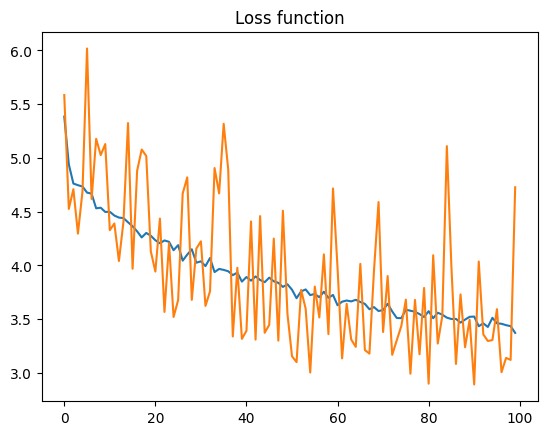

In [9]:
train_loss, test_loss = train_model(model, device, dl_train, dl_test, criterion, optimizer, epochs=100)
torch.save(model.state_dict(), f'models/model_basenn{time.time_ns()}.pth') # it will be saved, ...but just in case (rly doesnt make much sense)